### Load the libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig
from peft import PeftModel
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import spacy
from IPython.display import display
import ipywidgets as widgets


### Set parameters

In [2]:
model_name = 'meta-llama/Meta-Llama-3-8B'
adapters = '../standard_finetuned_models/outputmodel_Meta-Llama-3-8B_5_epochs'
test_data_path = '../dataset_splits/test_dataset.csv'
already_evaluated = 1
df_test = pd.read_csv(test_data_path)
shap_evaluation_path = '../saved_shap_values/Meta-Llama-3-8B_5_epochs_shap_values.pkl'

### Select the POS Tag used later for shapley values

* ADJ = Adjective
* NOUN = Noun
* VERB = Verb
* ADV = Adverb

In [3]:
selected_pos = 'ADJ'

### Load Configs

In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=2
)
peft_model = PeftModel.from_pretrained(model, adapters)

tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
peft_model.config.pad_token_id = tokenizer.pad_token_id
peft_model.config.use_cache = False

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
def shap_predict(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    elif isinstance(texts, str):
        texts = [texts]

    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(peft_model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = peft_model(**inputs)
    
    return outputs.logits.cpu().numpy()

In [6]:
if already_evaluated:
    with open(shap_evaluation_path, "rb") as f:
        all_shap_values = pickle.load(f)

else:
    masker = shap.maskers.Text(tokenizer)
    explainer = shap.Explainer(shap_predict, masker)

    batch_size = 10
    num_samples = len(df_test['Quote'])
    all_shap_values = []

    for i in range(0, num_samples, batch_size):
        batch_sentences = df_test['Quote'].tolist()[i:i + batch_size]
        
        shap_values = explainer(batch_sentences)
        all_shap_values.extend(shap_values)

    with open(shap_evaluation_path, "wb") as f:
        pickle.dump(all_shap_values, f)

### Code filter by Spacey and remove stopwords

In [7]:
nlp = spacy.load("en_core_web_sm")
token_influence_class_0 = defaultdict(list)
token_influence_class_1 = defaultdict(list)

stopwords = {"'d", "'s", "'ll", "'m", "'re", "n't", "the", "a", "an"}

def filter_by_pos(token, pos_tags=[selected_pos]):
    token = token.strip().lower()
    if token in stopwords or not token.isalpha():
        return False
    doc = nlp(token)
    return len(doc) > 0 and doc[0].pos_ in pos_tags

### Calculate and filter the Shap values

In [8]:
for sample_shap_values in all_shap_values:
    shap_tokens = sample_shap_values.data
    tokens = tokenizer.convert_ids_to_tokens(shap_tokens) if isinstance(shap_tokens[0], int) else shap_tokens

    for token_idx, token in enumerate(tokens):
        token = token.strip().lower()
        
        shap_value_class_0 = sample_shap_values.values[token_idx, 0]  # SHAP value for class 0
        shap_value_class_1 = sample_shap_values.values[token_idx, 1]  # SHAP value for class 1

        if filter_by_pos(token):
            token_influence_class_0[token].append(shap_value_class_0)
            token_influence_class_1[token].append(shap_value_class_1)

### Calculate the mean and median influences for each class

In [9]:
# Mean influences
mean_influence_class_0 = {token: np.mean(influences) for token, influences in token_influence_class_0.items()}
mean_influence_class_1 = {token: np.mean(influences) for token, influences in token_influence_class_1.items()}

# Median infleunces
median_influence_class_0 = {token: np.median(influences) for token, influences in token_influence_class_0.items()}
median_influence_class_1 = {token: np.median(influences) for token, influences in token_influence_class_1.items()}


### Sorting for class Memorable 

In [10]:
positive_influence_class_1_mean = {token: influence for token, influence in mean_influence_class_1.items() if influence > 0}
negative_influence_class_1_mean = {token: influence for token, influence in mean_influence_class_1.items() if influence < 0}

sorted_positive_influence_class_1_mean = sorted(positive_influence_class_1_mean.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
sorted_negative_influence_class_1_mean = sorted(negative_influence_class_1_mean.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

positive_influence_class_1_median = {token: influence for token, influence in median_influence_class_1.items() if influence > 0}
negative_influence_class_1_median = {token: influence for token, influence in median_influence_class_1.items() if influence < 0}

sorted_positive_influence_class_1_median = sorted(positive_influence_class_1_median.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
sorted_negative_influence_class_1_median = sorted(negative_influence_class_1_median.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

### Sorting for class Non-memorable

In [11]:
positive_influence_class_0_mean = {token: influence for token, influence in mean_influence_class_0.items() if influence > 0}
negative_influence_class_0_mean = {token: influence for token, influence in mean_influence_class_0.items() if influence < 0}

sorted_positive_influence_class_0_mean = sorted(positive_influence_class_0_mean.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
sorted_negative_influence_class_0_mean = sorted(negative_influence_class_0_mean.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

positive_influence_class_0_median = {token: influence for token, influence in median_influence_class_0.items() if influence > 0}
negative_influence_class_0_median = {token: influence for token, influence in median_influence_class_0.items() if influence < 0}

sorted_positive_influence_class_0_median = sorted(positive_influence_class_0_median.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
sorted_negative_influence_class_0_median = sorted(negative_influence_class_0_median.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

### Print values memorable class

In [ ]:
print("Top 10 positive influence tokens for memorable - Mean:", sorted_positive_influence_class_1_mean)
print("Top 10 negative influence tokens for memorable - Mean:", sorted_negative_influence_class_1_mean)
print("Top 10 positive influence tokens for memorable - Median:", sorted_positive_influence_class_1_median)
print("Top 10 negative influence tokens for memorable - Median:", sorted_negative_influence_class_1_median)

Top 10 positive influence tokens for class 1 (Memorable) - Mean: [('lucky', np.float64(2.908355712890625)), ('slow', np.float64(2.6264190673828125)), ('worth', np.float64(2.40606689453125)), ('happy', np.float64(2.146808624267578)), ('paragus', np.float64(1.7437744140625)), ('gorgeous', np.float64(1.6810302734375)), ('famous', np.float64(1.6504287719726562)), ('effective', np.float64(1.6387939453125)), ('sharp', np.float64(1.4757614135742188)), ('real', np.float64(1.4189354578653972))]
Top 10 negative influence tokens for class 1 (Memorable) - Mean: [('secure', np.float64(-2.17822265625)), ('large', np.float64(-1.6891708374023438)), ('portable', np.float64(-1.65325927734375)), ('easy', np.float64(-1.242340087890625)), ('comfortable', np.float64(-1.23858642578125)), ('dict', np.float64(-1.05126953125)), ('knowledgeable', np.float64(-0.9527435302734375)), ('unable', np.float64(-0.9228439331054688)), ('bigger', np.float64(-0.8523368835449219)), ('poor', np.float64(-0.7757568359375))]
Top 

### Print values Non-memorable class

In [ ]:
print("Top 10 positive influence tokens for class non-memroable - Mean:", sorted_positive_influence_class_0_mean)
print("Top 10 negative influence tokens for class 0 non-memroable - Mean:", sorted_negative_influence_class_0_mean)
print("Top 10 positive influence tokens for class 0 non-memroable - Median:", sorted_positive_influence_class_0_median)
print("Top 10 negative influence tokens for class 0 non-memroable - Median:", sorted_negative_influence_class_0_median)

Top 10 positive influence tokens for class 0 (Non-memorable) - Mean: [('ewitness', np.float64(0.7202386856079102)), ('gorgeous', np.float64(0.638916015625)), ('ricky', np.float64(0.569976806640625)), ('slow', np.float64(0.51019287109375)), ('numerous', np.float64(0.41869354248046875)), ('coolest', np.float64(0.396728515625)), ('sexy', np.float64(0.39009833335876465)), ('beautiful', np.float64(0.35917091369628906)), ('dramatic', np.float64(0.3455390930175781)), ('unde', np.float64(0.298583984375))]
Top 10 negative influence tokens for class 0 (Non-memorable) - Mean: [('paragus', np.float64(-3.598876953125)), ('awake', np.float64(-2.3213043212890625)), ('small', np.float64(-2.253570556640625)), ('meaningless', np.float64(-2.1278076171875)), ('facial', np.float64(-2.0257415771484375)), ('tasty', np.float64(-1.8169097900390625)), ('sted', np.float64(-1.4798583984375)), ('warm', np.float64(-1.32568359375)), ('fine', np.float64(-1.321014404296875)), ('stupid', np.float64(-1.2799530029296875)

### Plot for memorable class

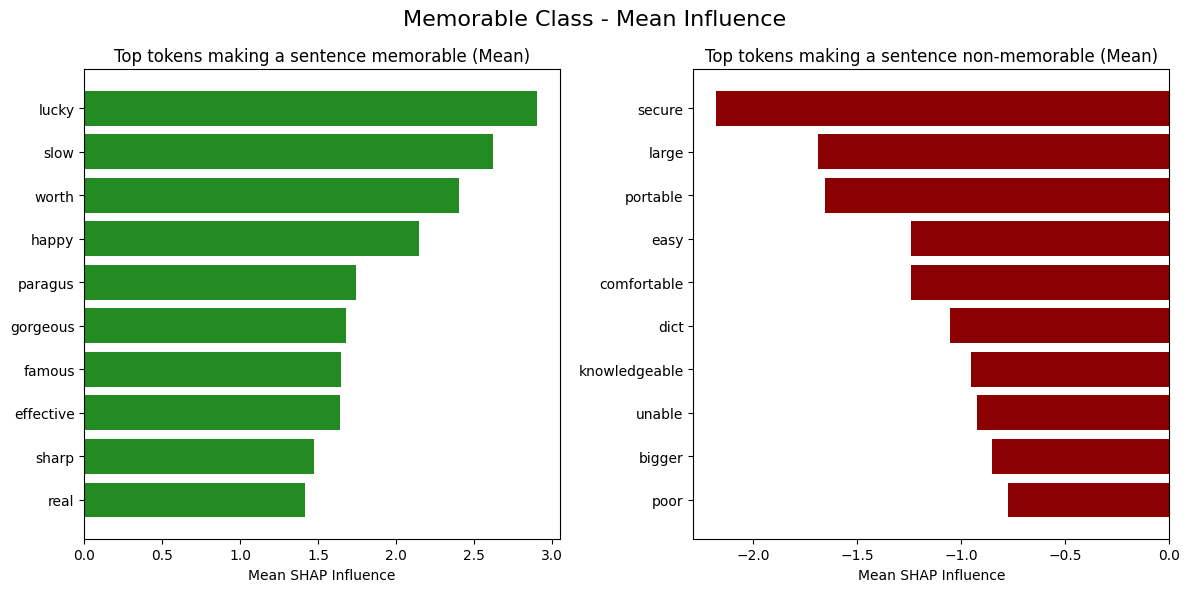

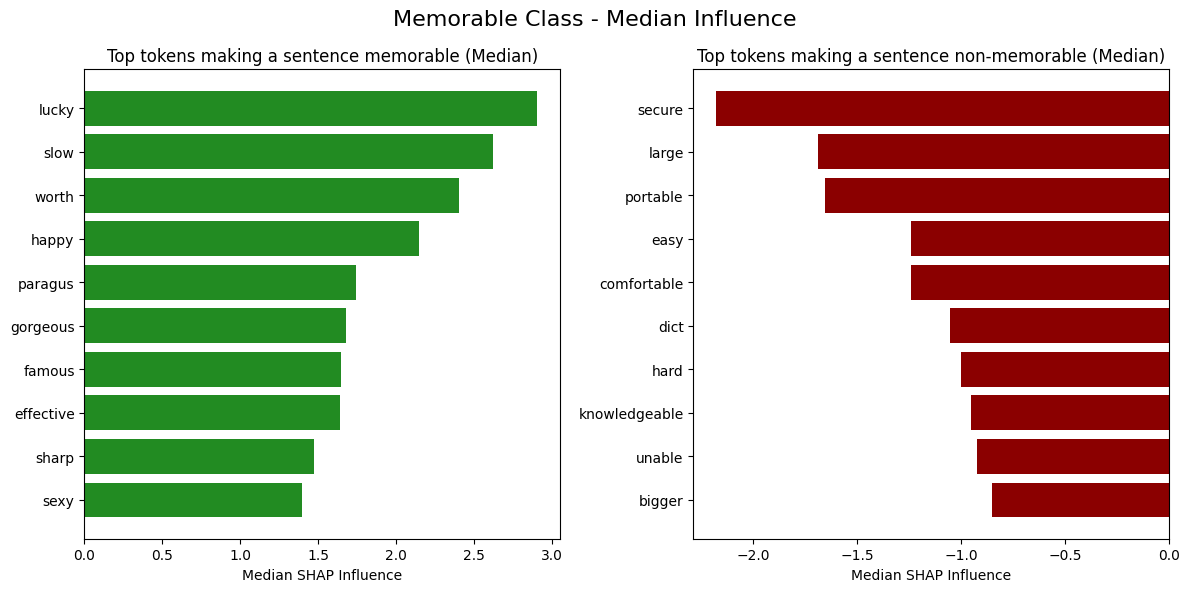

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle("Memorable Class - Mean", fontsize=16)

plt.subplot(1, 2, 1)
plt.barh([token for token, _ in sorted_positive_influence_class_1_mean], 
         [influence for _, influence in sorted_positive_influence_class_1_mean], 
         color="forestgreen")
plt.xlabel("Mean SHAP Influence")
plt.title("Top tokens positive influence")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh([token for token, _ in sorted_negative_influence_class_1_mean], 
         [influence for _, influence in sorted_negative_influence_class_1_mean], 
         color="darkred")
plt.xlabel("Mean SHAP Influence")
plt.title("Top tokens negative influence")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
plt.savefig('../figures/memorable_mean_shap.png')


plt.figure(figsize=(12, 6))
plt.suptitle("Memorable Class - Median", fontsize=16)

plt.subplot(1, 2, 1)
plt.barh([token for token, _ in sorted_positive_influence_class_1_median], 
         [influence for _, influence in sorted_positive_influence_class_1_median], 
         color="forestgreen")
plt.xlabel("Median SHAP Influence")
plt.title("Top tokens positive influence")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh([token for token, _ in sorted_negative_influence_class_1_median], 
         [influence for _, influence in sorted_negative_influence_class_1_median], 
         color="darkred")
plt.xlabel("Median SHAP Influence")
plt.title("Top tokens negative influence")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
plt.savefig('../figures/memorable_median_shap.png')

### Plot for non-memorable Class

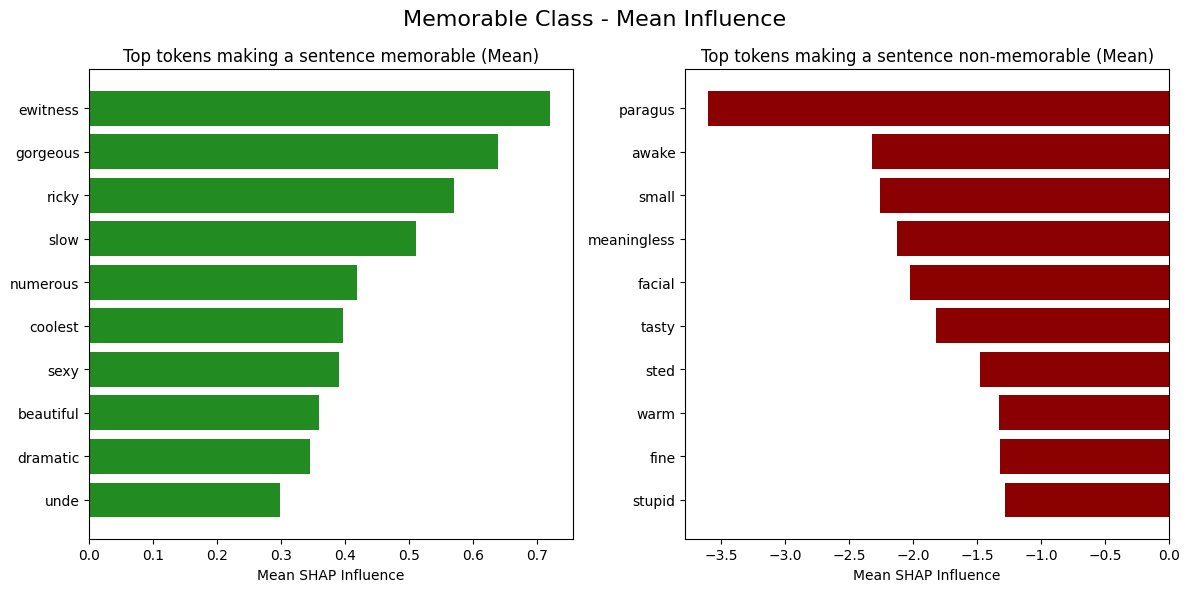

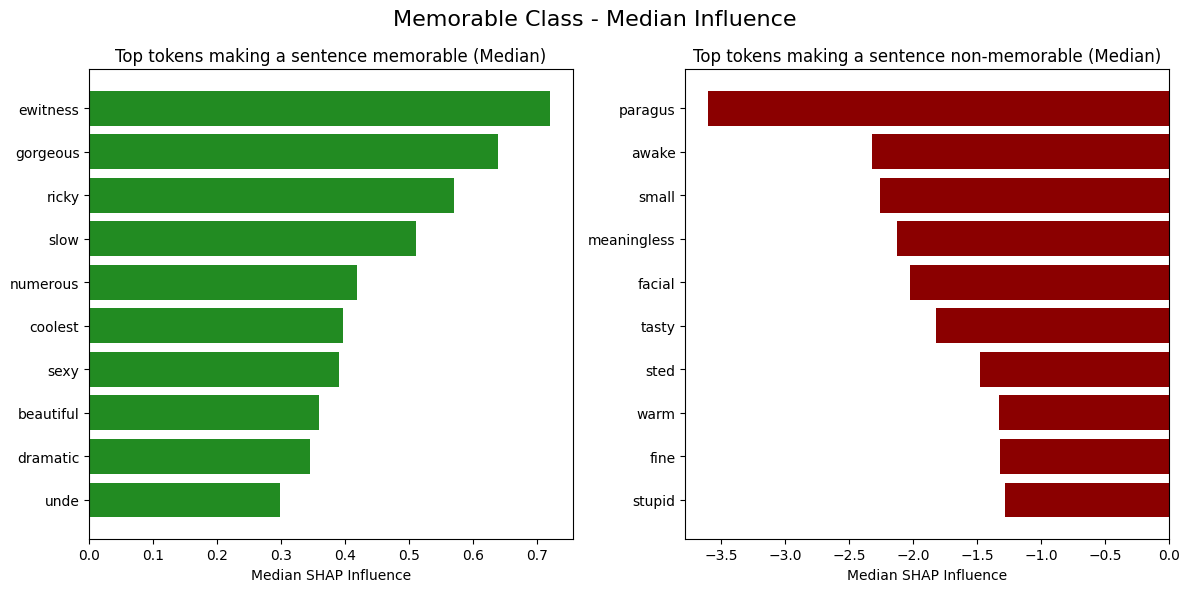

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle("Non-memorable Class - Mean ", fontsize=16)

plt.subplot(1, 2, 1)
plt.barh([token for token, _ in sorted_positive_influence_class_0_mean], 
         [influence for _, influence in sorted_positive_influence_class_0_mean], 
         color="forestgreen")
plt.xlabel("Mean SHAP Influence")
plt.title("Top tokens positive influence")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh([token for token, _ in sorted_negative_influence_class_0_mean], 
         [influence for _, influence in sorted_negative_influence_class_0_mean], 
         color="darkred")
plt.xlabel("Mean SHAP Influence")
plt.title("Top tokens negative influence")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
plt.savefig('../figures/non_memorable_mean_shap.png')

plt.figure(figsize=(12, 6))
plt.suptitle("Non-emorable Class - Median", fontsize=16)

plt.subplot(1, 2, 1)
plt.barh([token for token, _ in sorted_positive_influence_class_0_median], 
         [influence for _, influence in sorted_positive_influence_class_0_median], 
         color="forestgreen")
plt.xlabel("Median SHAP Influence")
plt.title("Top tokens positive influence")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh([token for token, _ in sorted_negative_influence_class_0_median], 
         [influence for _, influence in sorted_negative_influence_class_0_median], 
         color="darkred")
plt.xlabel("Median SHAP Influence")
plt.title("Top tokens negative influence")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
plt.savefig('../figures/non_memorable_median_shap.png')